## Kamień milowy 2 - *Ewaluacja AutoPyTorch na zbiorach z OpenML*
Adam Frej, Łukasz Tomaszewski, Marcel Witas 



Wykonaliśmy benchmark na 22 zbiorach z OpenML dotyczących binarnej klasyfikacji. Każdy zbiór miał zdefiniowane 10 foldów do kroswalidacji. AutoPyTorch ma możliwość stosowania kroswalidacji, ale jest ona tylko losowa (nie da się stosować własnych podziałów). Z tego powodu wywoływaliśmy framework osobno dla każdego folda i zapisywaliśmy wynik.

Aby framework został zastosowany do zdefiniowanych przez OpenML foldach kroswalidacji, użyliśmy poniższej funkcji.
Wywołana została dla każdego zbioru danych i każdego foldu. Ponieważ na początku ustawione limity czasu (parametry *total_walltime_limit* i *func_eval_time_limit_secs*) pozwalały wytrenować jedynie DummyClassifier, były zwiększane, metodą prób i błędów. Znaczenie miał nie tylko całkowity czas, ale także czas na trening pojedynczego modelu, który z kolei nie mógł być zbyt wysoki. Trzeba było znaleźć balans pomiędzy liczbą zbiorów, która polepsza ensembling oraz rozsądnym czasem trenowania.

In [10]:
import pandas as pd
import openml
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
def run(dataframe, target_name, fold_train, fold_test):
    
    data_train = dataframe.loc[fold_train]
    data_test = dataframe.loc[fold_test]
    X_train = data_train.drop(target_name, axis=1)
    y_train = data_train[target_name]
    X_test = data_test.drop(target_name, axis=1)
    y_test = data_test[target_name]
    
    X_train,y_train =  pipeline(X_train,y_train)
    X_test, y_test = pipeline(X_test, y_test)
    
    
    api = TabularClassificationTask()
    api.search(X_train= X_train, y_train= y_train,X_test = X_test,
                      y_test = y_test, optimize_metric='roc_auc',total_walltime_limit=360, 
               func_eval_time_limit_secs=40,  memory_limit=None) 
    y_pred = api.predict_proba(X_test)
    
    score = roc_auc_score(y_test, y_pred[:, 1])
    
    return api, score

Ostacznie użyto różnych czasów dla różnych zbiorów danych. Optymalizowaną metryką, było ROC AUC.
Oprócz scoringu, zapisywaliśmy tabelę z informacją jakie modele, z jakim preprocessingiem oraz wagą weszły do ensemblingu.

## Wyniki
Wyniki ewaluacji zostaną przedstawione na wykresie. Pokazane są osobne wyniki każdego folda dla każdego zbioru. Zbiory są pogrupowane ze wzgledu na czas trenowania.

In [11]:
df= pd.read_csv('plot_df.csv', index_col = 0)

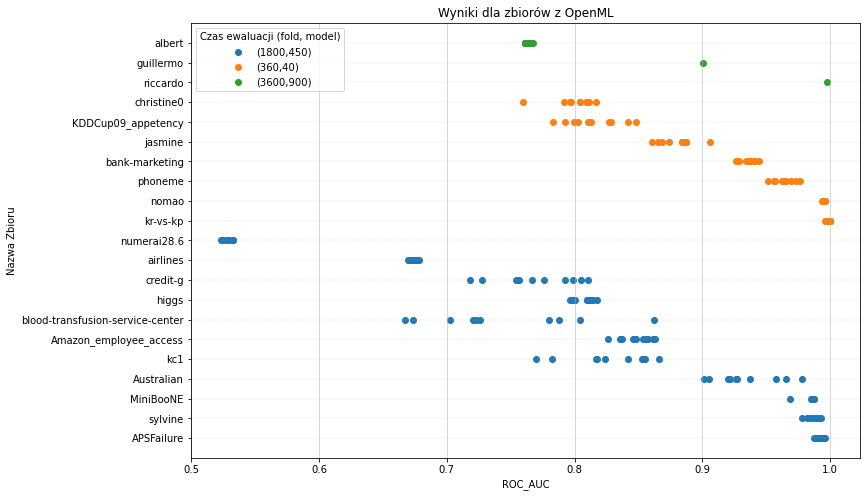

In [12]:
plt.figure(figsize=(12, 8))
groups = df.groupby('time')
for name, group in groups:
    plt.scatter(group.score, group.dataset, label=name)

plt.grid(axis = 'y', linestyle = '--', linewidth = 0.2)
plt.grid(axis = 'x', linewidth = 0.5)    
plt.legend(title = "Czas ewaluacji (fold, model)")
plt.xlabel("ROC_AUC")
plt.ylabel("Nazwa Zbioru")
plt.title("Wyniki dla zbiorów z OpenML")
plt.show()

#### Uwagi do wykresu

* Na zbiorach guillermo i riccardo funkcja z różnych powodów wykonała się tylko na jednym foldzie. Prawdopodobnie miał na to wpływ bardzo duży rozmiar tych zbiorów danych.
* Czas ewaluacji podany jest w sekundach, zatem:
** 3 zbiory były trenowane przez godzinę na fold, 
** 7 zbiórów przez 6 minut na fold,
** 12 zbiorów przez 30 minut na fold

In [22]:
folders = os.listdir('scores/')
folders.remove('.ipynb_checkpoints',)
wyniki = {}          

for file_name in folders:
    data_file = 'scores/' + file_name
    score = pd.read_csv(data_file)
    wyniki.update({file_name: score})

W danych na temat tego, jakie modele były używane przez framework, możemy zauważyć dziwne zależności. Różnice pomiędzy pierwszym foldem, a pozostałymi, są z reguły bardzo widoczne. 
Na pierwszym foldzie uczone były sieci neuronowe i wykonywany preprocessing. W pozostałych, ensembling składał się jedynie z kilku tradycyjnych modeli bez
preprocessingu. Trudno powiedzieć, z czego to wynika.

#### Przykładowe modele dla pierwszego foldu.

In [25]:
print(wyniki['10101.csv'].iloc[0,1 ])

|    | Preprocessing                                               | Estimator                                                          |   Weight |
|---:|:------------------------------------------------------------|:-------------------------------------------------------------------|---------:|
|  0 | SimpleImputer,NoEncoder,StandardScaler,PowerTransformer     | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential    |     0.7  |
|  1 | SimpleImputer,NoEncoder,StandardScaler,PowerTransformer     | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential    |     0.12 |
|  2 | SimpleImputer,NoEncoder,MinMaxScaler,NoFeaturePreprocessing | no embedding,ShapedResNetBackbone,FullyConnectedHead,nn.Sequential |     0.04 |
|  3 | SimpleImputer,NoEncoder,Normalizer,KitchenSink              | no embedding,ShapedMLPBackbone,FullyConnectedHead,nn.Sequential    |     0.02 |
|  4 | SimpleImputer,NoEncoder,MinMaxScaler,PowerTransformer       | no embedding,ShapedResNetBackbone,Ful

#### Przykładowe modele dla innych foldów.

In [26]:
print(wyniki['10101.csv'].iloc[7,1])
print(wyniki['10101.csv'].iloc[5,1])

|    | Preprocessing   | Estimator   |   Weight |
|---:|:----------------|:------------|---------:|
|  0 | None            | CBLearner   |     0.94 |
|  1 | None            | RFLearner   |     0.06 |
|    | Preprocessing   | Estimator   |   Weight |
|---:|:----------------|:------------|---------:|
|  0 | None            | CBLearner   |     0.9  |
|  1 | None            | KNNLearner  |     0.08 |
|  2 | None            | RFLearner   |     0.02 |


Kod potrzebny do wygenerowania wykresów.

In [42]:
modele = []
neu =[]
for file in folders:
    df = wyniki[file]
    words = df.iloc[0, 1].split() 
    for k in range(len(words)):
            neu.append(words[k]) 
    for i in range(1, 10):
        words = df.iloc[i, 1].split() 
        for j in range(len(words)):
            modele.append(words[j])
            
m = []            
for s in neu:
    if "embedding" in s or "Learner" in s:
        m.append(s)
        
modele_kl = []            
for s in modele:
    if "embedding" in s or "Learner" in s:
        modele_kl.append(s)
            
i = 0
for s in m:
    if "embedding" in s:
        m[i] = s.split(',')[1]
    i+=1

#### Modele użyte w pierwszych foldach.

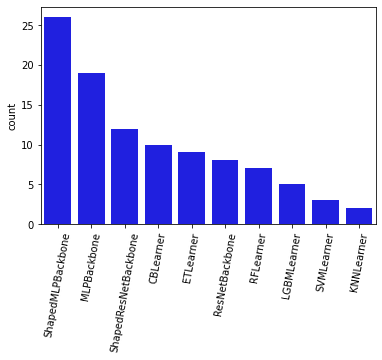

In [39]:
sns.countplot(x = m, color = 'b',  order = pd.Series(m).value_counts().index)
plt.xticks(rotation=80)
plt.show()

#### Modele użyte w pozostałych foldach.

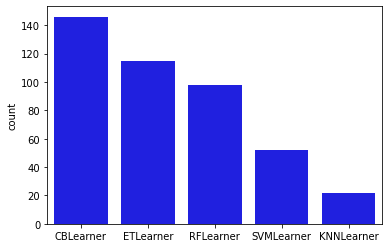

In [43]:
sns.countplot(x = modele_kl, color = 'b',  order = pd.Series(modele_kl).value_counts().index)
plt.show()

## Podsumowanie

* Z większością zbiorów danych AutoPyTorch poradził sobie naprawdę dobrze - ROC AUC było przeważnie powyżej 0.8.
* Dla niektórych zbiorów wariancja wyników była dość wysoka.
* Dla większości tasków AutoPyTorch osiągnął podobne wyniki, co pakiety testowane w benchmarku, chociaż warto podkreślić, że autorzy artykułu stosowali dużo wyższe czasy trenowania. 